# Bank Marketing Term Deposit Prediction

In [1]:
import json
import joblib
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    RocCurveDisplay,
    PrecisionRecallDisplay,
    average_precision_score,
    classification_report,
    confusion_matrix,
    f1_score,
    roc_auc_score,
    precision_recall_curve,
)
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_score, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

RANDOM_STATE = 42
DATA_PATH = Path('bank-additional.csv')
ARTIFACT_DIR = Path('artifacts')
ARTIFACT_DIR.mkdir(exist_ok=True)



In [2]:
# Load data

df = pd.read_csv(DATA_PATH, sep=';')
print('Shape:', df.shape)
print('\nPreview:')
display(df.head())

print('\nTarget distribution:')
print(df['y'].value_counts(normalize=True).rename('proportion'))


Shape: (4119, 21)

Preview:


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no



Target distribution:
y
no     0.890507
yes    0.109493
Name: proportion, dtype: float64


In [3]:
# Basic cleaning: treat 'unknown' as missing for categorical cols

df_clean = df.copy()
cat_cols = df_clean.select_dtypes(include=['object']).columns.tolist()
cat_cols.remove('y')
for col in cat_cols:
    df_clean[col] = df_clean[col].replace('unknown', np.nan)

# --- Feature engineering: pdays handling ---
# Flag whether the client was contacted before; 999 means never contacted
# Replace pdays=999 with -1 to avoid misleading distance for models
if 'pdays' not in df_clean.columns:
    df_clean['pdays'] = -1  # default: not contacted

df_clean['was_contacted'] = np.where(df_clean['pdays'] == 999, 0, 1)
df_clean['pdays'] = df_clean['pdays'].replace(999, -1)

print('Missing values after marking unknowns and pdays tweaks:')
print(df_clean.isna().sum())



Missing values after marking unknowns and pdays tweaks:
age                 0
job                39
marital            11
education         167
default           803
housing           105
loan              105
contact             0
month               0
day_of_week         0
duration            0
campaign            0
pdays               0
previous            0
poutcome            0
emp.var.rate        0
cons.price.idx      0
cons.conf.idx       0
euribor3m           0
nr.employed         0
y                   0
was_contacted       0
dtype: int64


In [4]:
# Train/validation/test split
# - test: final, untouched evaluation
# - validation: calibration + threshold selection
# - train: model fitting + CV/tuning

X = df_clean.drop(columns=['y'])
y = df_clean['y'].map({'no': 0, 'yes': 1})

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# validation is 25% of trainval => 20% of full data
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=RANDOM_STATE, stratify=y_trainval
)

print('Train size:', X_train.shape)
print('Val size:', X_val.shape)
print('Test size:', X_test.shape)



Train size: (2471, 21)
Val size: (824, 21)
Test size: (824, 21)


In [5]:
# Preprocessing + feature selection

num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()

numeric_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore')),
    ]
)

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols),
    ]
)

selector = SelectKBest(mutual_info_classif, k=30)



In [6]:
# Compare baseline models via PR-AUC (Average Precision)
# (PR-AUC is usually more informative than ROC-AUC under strong class imbalance.)

models = {
    'log_reg': LogisticRegression(max_iter=2000, class_weight='balanced', random_state=RANDOM_STATE),
    'rf': RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE),
    'gboost': GradientBoostingClassifier(random_state=RANDOM_STATE),
    'mlp': MLPClassifier(hidden_layer_sizes=(50,), max_iter=800, random_state=RANDOM_STATE),
}

# Optional: add XGBoost if installed
try:
    from xgboost import XGBClassifier

    models['xgboost'] = XGBClassifier(
        scale_pos_weight=9,
        random_state=RANDOM_STATE,
        eval_metric='logloss',
        use_label_encoder=False,
    )
    print('XGBoost eklendi.')
except ImportError:
    print('XGBoost kütüphanesi bulunamadı, mevcut modellerle devam ediliyor.')

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

results = {}
for name, clf in models.items():
    pipe = Pipeline([
        ('preprocess', preprocess),
        ('selector', selector),
        ('clf', clf),
    ])
    ap = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='average_precision', n_jobs=-1)
    roc = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
    results[name] = {
        'pr_auc_mean': ap.mean(),
        'pr_auc_std': ap.std(),
        'roc_auc_mean': roc.mean(),
        'roc_auc_std': roc.std(),
    }

results_df = pd.DataFrame(results).T.sort_values('pr_auc_mean', ascending=False)
print(results_df)
best_name = results_df.index[0]
print('\nBest baseline model (by PR-AUC):', best_name)



XGBoost eklendi.


/Users/kaancakir/ADA442Project/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kaancakir/ADA442Project/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kaancakir/ADA442Project/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kaancakir/ADA442Project/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged ye

         pr_auc_mean  pr_auc_std  roc_auc_mean  roc_auc_std
log_reg     0.597104    0.064065      0.932779     0.014627
gboost      0.582127    0.062645      0.922470     0.017483
rf          0.563323    0.031598      0.918350     0.013948
xgboost     0.559949    0.066122      0.911308     0.013431
mlp         0.549938    0.061596      0.891524     0.006829

Best baseline model (by PR-AUC): log_reg


/Users/kaancakir/ADA442Project/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [17:45:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/kaancakir/ADA442Project/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [17:45:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/kaancakir/ADA442Project/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [17:45:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/kaancakir/ADA442Project/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [17:45:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:7

In [7]:
# Hyperparameter tuning for the best baseline (optimize PR-AUC)

base_clf = models[best_name]

param_distributions = {}
if best_name == 'log_reg':
    # NOTE: scikit-learn 1.8 deprecates explicit 'penalty' arg here; keep default (L2) and tune C/solver.
    param_distributions = {
        'clf__C': np.logspace(-2, 2, 12),
        'clf__solver': ['lbfgs', 'liblinear'],
    }
elif best_name == 'rf':
    param_distributions = {
        'clf__n_estimators': [200, 400, 800],
        'clf__max_depth': [None, 6, 10, 20],
        'clf__max_features': ['sqrt', 0.5, 0.8],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4],
    }
elif best_name == 'gboost':
    param_distributions = {
        'clf__n_estimators': [150, 300, 600],
        'clf__learning_rate': [0.01, 0.03, 0.05, 0.1],
        'clf__max_depth': [2, 3, 4],
        'clf__subsample': [0.7, 0.85, 1.0],
    }
else:  # mlp
    param_distributions = {
        'clf__hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'clf__alpha': [1e-5, 1e-4, 1e-3, 1e-2],
        'clf__learning_rate_init': [0.0005, 0.001, 0.01],
    }

search_pipe = Pipeline([
    ('preprocess', preprocess),
    ('selector', selector),
    ('clf', base_clf),
])

search = RandomizedSearchCV(
    search_pipe,
    param_distributions=param_distributions,
    n_iter=20,
    scoring='average_precision',
    cv=cv,
    n_jobs=-1,
    random_state=RANDOM_STATE,
)

search.fit(X_train, y_train)
print('Best params:', search.best_params_)
print('Best CV PR-AUC (AP):', search.best_score_)

best_model = search.best_estimator_



Best params: {'clf__solver': 'lbfgs', 'clf__C': np.float64(0.0533669923120631)}
Best CV PR-AUC (AP): 0.6192031272972207



Selected threshold (cost-based): 0.484287
Validation confusion (tn, fp, fn, tp): (642, 92, 8, 82)

TEST metrics (probabilities from model, no calibration):
PR-AUC (AP): 0.6222756931634934
ROC-AUC: 0.9396457765667575
F1 @ selected threshold: 0.5992217898832685

Classification report (selected threshold):
               precision    recall  f1-score   support

           0       0.98      0.88      0.93       734
           1       0.46      0.86      0.60        90

    accuracy                           0.88       824
   macro avg       0.72      0.87      0.76       824
weighted avg       0.92      0.88      0.89       824



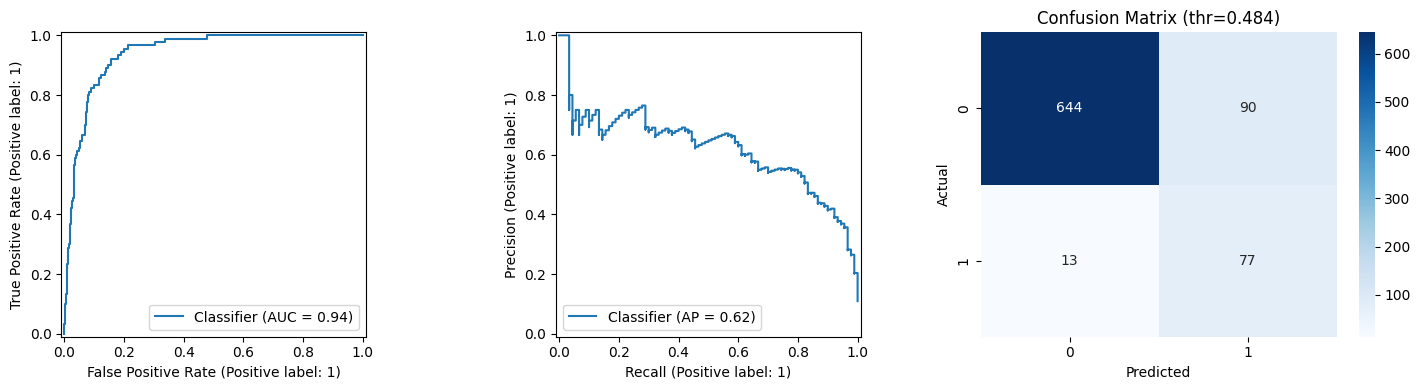

In [8]:
# Validation-based threshold selection (NO calibration)
# - Fit model on train
# - Choose threshold on validation (cost-based or recall-constrained)
# - Evaluate ONCE on the untouched test set

best_model.fit(X_train, y_train)

# --- threshold selection on validation ---
y_val_proba = best_model.predict_proba(X_val)[:, 1]

threshold_grid = np.unique(np.r_[0.0, np.round(y_val_proba, 6), 1.0])

def select_threshold_cost_based(y_true, y_proba, cost_fp=1.0, cost_fn=5.0):
    # minimize: cost = cost_fn*FN + cost_fp*FP
    best = {'threshold': 0.5, 'cost': float('inf')}
    for t in threshold_grid:
        y_pred = (y_proba >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
        cost = cost_fn * fn + cost_fp * fp
        if cost < best['cost']:
            best = {'threshold': float(t), 'cost': float(cost), 'tn': int(tn), 'fp': int(fp), 'fn': int(fn), 'tp': int(tp)}
    return best

def select_threshold_recall_constrained(y_true, y_proba, min_recall=0.80):
    best = None
    for t in threshold_grid:
        y_pred = (y_proba >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
        recall = tp / (tp + fn + 1e-12)
        precision = tp / (tp + fp + 1e-12)
        if recall + 1e-12 < min_recall:
            continue
        # among thresholds satisfying recall, prefer higher precision; tie-breaker: higher threshold
        cand = {'threshold': float(t), 'recall': float(recall), 'precision': float(precision), 'tn': int(tn), 'fp': int(fp), 'fn': int(fn), 'tp': int(tp)}
        if best is None or (cand['precision'] > best['precision']) or (cand['precision'] == best['precision'] and cand['threshold'] > best['threshold']):
            best = cand
    return best

# Choose ONE strategy here
THRESHOLD_STRATEGY = 'cost_based'  # 'cost_based' or 'recall_constrained'

if THRESHOLD_STRATEGY == 'cost_based':
    thr_info = select_threshold_cost_based(y_val, y_val_proba, cost_fp=1.0, cost_fn=5.0)
    threshold = thr_info['threshold']
    print('\nSelected threshold (cost-based):', threshold)
    print('Validation confusion (tn, fp, fn, tp):', (thr_info['tn'], thr_info['fp'], thr_info['fn'], thr_info['tp']))
else:
    thr_info = select_threshold_recall_constrained(y_val, y_val_proba, min_recall=0.80)
    if thr_info is None:
        threshold = 0.5
        print('\nNo threshold met recall constraint; falling back to 0.5')
    else:
        threshold = thr_info['threshold']
        print('\nSelected threshold (recall-constrained):', threshold)
        print('Validation precision/recall:', (thr_info['precision'], thr_info['recall']))
        print('Validation confusion (tn, fp, fn, tp):', (thr_info['tn'], thr_info['fp'], thr_info['fn'], thr_info['tp']))

# --- Evaluate on test set (single shot) ---
y_test_proba = best_model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= threshold).astype(int)

test_pr_auc = average_precision_score(y_test, y_test_proba)
test_roc_auc = roc_auc_score(y_test, y_test_proba)
test_f1 = f1_score(y_test, y_test_pred)

print('\nTEST metrics (probabilities from model, no calibration):')
print('PR-AUC (AP):', test_pr_auc)
print('ROC-AUC:', test_roc_auc)
print('F1 @ selected threshold:', test_f1)
print('\nClassification report (selected threshold):\n', classification_report(y_test, y_test_pred))

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
RocCurveDisplay.from_predictions(y_test, y_test_proba, ax=axes[0])
PrecisionRecallDisplay.from_predictions(y_test, y_test_proba, ax=axes[1])
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[2])
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')
axes[2].set_title(f'Confusion Matrix (thr={threshold:.3f})')
plt.tight_layout()
plt.show()



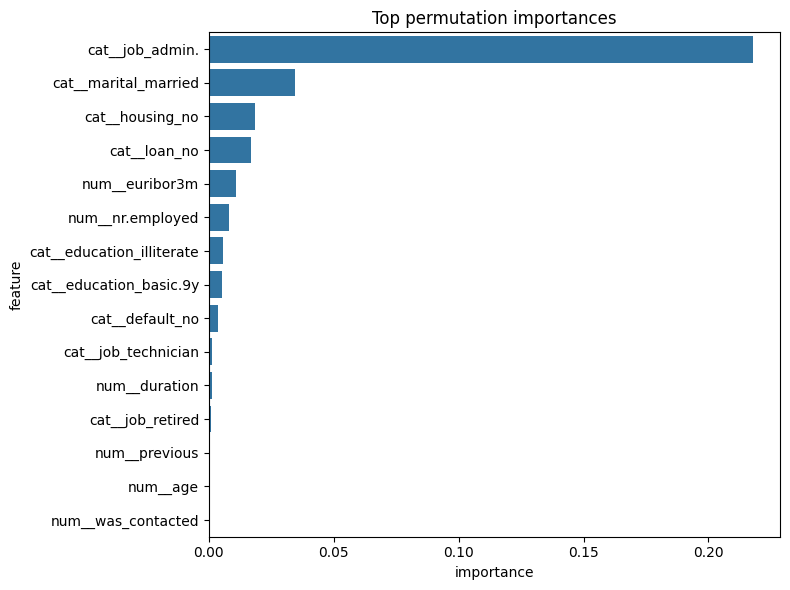

In [9]:
# Feature importance via permutation importance on test set

from sklearn.inspection import permutation_importance

perm = permutation_importance(
    best_model,
    X_test,
    y_test,
    n_repeats=10,
    random_state=RANDOM_STATE,
    scoring='roc_auc'
)

# Map back to feature names after preprocessing/selection
feature_names = best_model.named_steps['preprocess'].get_feature_names_out()
selected_mask = best_model.named_steps['selector'].get_support()
selected_features = feature_names[selected_mask]

# Align lengths in case of any mismatch
n = min(len(selected_features), len(perm.importances_mean))
importances = pd.DataFrame({
    'feature': selected_features[:n],
    'importance': perm.importances_mean[:n]
}).sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(8, 6))
sns.barplot(data=importances, y='feature', x='importance')
plt.title('Top permutation importances')
plt.tight_layout()
plt.show()



In [10]:
# Persist model + decision threshold + metrics for Streamlit (NO calibration)

MODEL_PATH = ARTIFACT_DIR / 'final_model.pkl'
METRICS_PATH = ARTIFACT_DIR / 'metrics.json'

joblib.dump(best_model, MODEL_PATH)

metrics = {
    'best_model': best_name,
    'best_params': search.best_params_,
    'selection_metric': 'average_precision',
    'calibration': None,
    'threshold': {
        'strategy': THRESHOLD_STRATEGY,
        'value': float(threshold),
        'details': thr_info,
    },
    'test_metrics': {
        'pr_auc': float(test_pr_auc),
        'roc_auc': float(test_roc_auc),
        'f1_at_threshold': float(test_f1),
    },
}

METRICS_PATH.write_text(json.dumps(metrics, indent=2))

print('Saved model to', MODEL_PATH)
print('Saved metrics to', METRICS_PATH)



Saved model to artifacts/final_model.pkl
Saved metrics to artifacts/metrics.json
